# Gibbs sampling 01

#### Josep Fortiana 2018-12-05

## Exercise 1

Review (see `Monte.Carlo.01.slides`) the properties of the bivariate normal pdf given in a previous lesson. In particular, if:

$$
	(X,Y)\sim\operatorname{BivN}\left((\mu_{x},\mu_{y}),
									\left(\begin{array}{cc}
									\sigma_{x}^{2}    &\rho\sigma_{x}\sigma_{y}\\
									\rho\sigma_{x}\sigma_{y}&\sigma_{y}^{2}
									\end{array}\right)\right),
$$

then the conditional pdf's are:
    
$$
    \begin{array}{ccl}
	Y\,|\,X=x	&\sim &\operatorname{N}(\mu_{y|x},\sigma^{2}_{y|x}),\\
	X\,|\,Y=y	&\sim &\operatorname{N}(\mu_{x|y},\sigma^{2}_{x|y}),
    \end{array}
$$

where

$$
    \begin{array}{ccl}
	\mu_{y|x}	&=\mu_{y}+\rho\cdot\dfrac{\sigma_{y}}{\sigma_{x}}\cdot(x-\mu_{x}),\\
	\sigma^{2}_{y|x}&=\sigma^{2}_{y}\cdot(1-\rho^{2}),\\
	\mu_{x|y}	&=\mu_{x}+\rho\cdot\dfrac{\sigma_{x}}{\sigma_{y}}\cdot(y-\mu_{y}),\\
	\sigma^{2}_{x|y}&=\sigma^{2}_{x}\cdot(1-\rho^{2}).
    \end{array}
$$

Write and run a Gibbs sampler code for the bivariate normal pdf.

#### Load required packages

In [1]:
#install.packages("hexbin", repos= "https://cloud.r-project.org")
#install.packages("RColorBrewer", repos= "https://cloud.r-project.org")
require(MASS)
require(hexbin)
require(RColorBrewer)

Loading required package: MASS
Warning message:
"package 'MASS' was built under R version 3.4.3"Loading required package: hexbin
Warning message:
"package 'hexbin' was built under R version 3.4.3"Loading required package: RColorBrewer


#### Target pdf: a bivariate gaussian

In [2]:
Biv.Normal.pdf<-function(xy,sx=1,sy=1,rho=0){
    x<-xy[1]/sx
    y<-xy[2]/sy
    t<-1/(1-rho^2)
    Q<-t*(x^2+y^2-2*rho*x*y)
    C<-sqrt(t)/2*pi
    return(C*exp(-Q/2))
    }

#### Adapt the pdf function for plotting a contour plot and for the Metropolis chain

In [3]:
f<-function(x,y){Biv.Normal.pdf(c(x,y),sx=sx,sy=sy,rho=rho)}
vf<-Vectorize(f)
target.f<-function(xy){Biv.Normal.pdf(xy,sx=sx,sy=sy,rho=rho)}

#### Set target pdf parameters

In [4]:
sx<-1.8
sy<-1.0
rho<-0.65

#### Plot perspective and contour plot

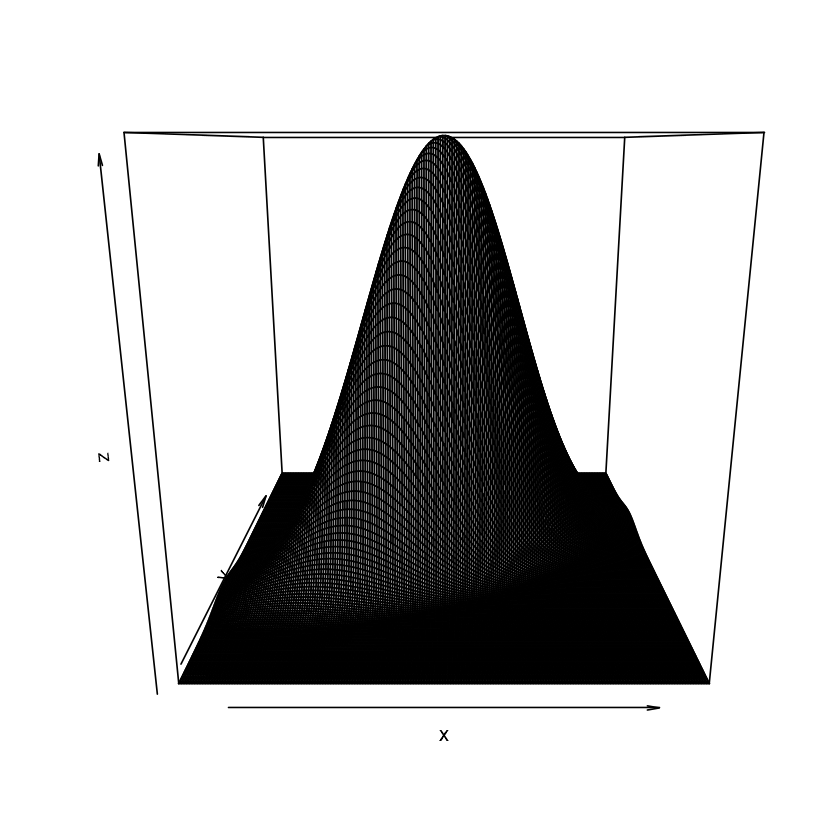

In [5]:
x<-seq(-5,5,length=200)
y<-seq(-5,5,length=200)
z<-outer(x,y,"vf")
persp(x,y,z)

#### Contour plot

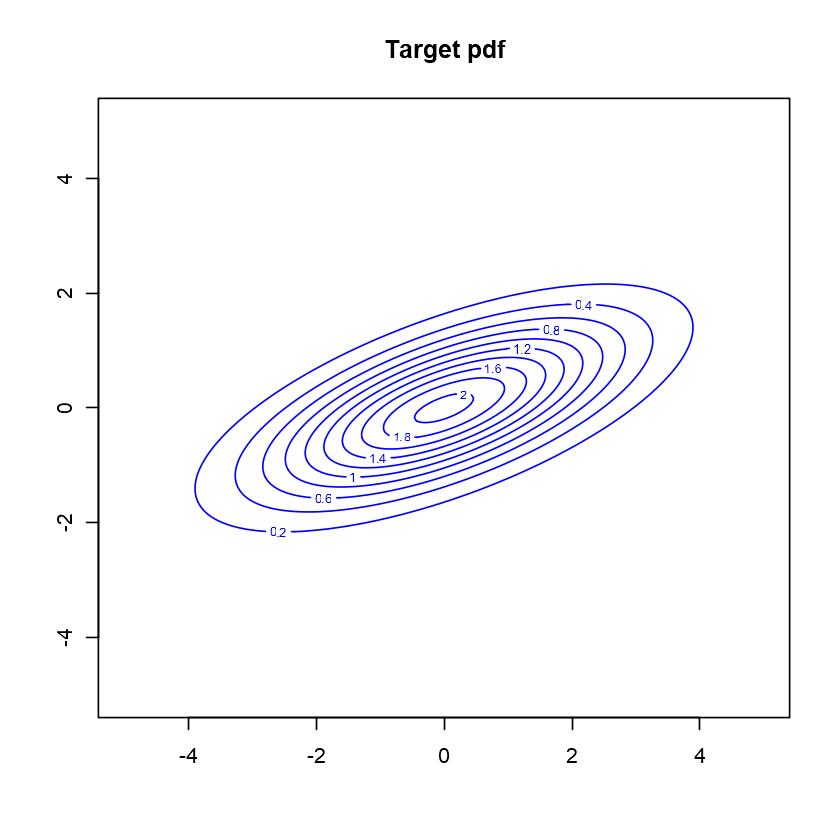

In [6]:
contour(x,y,z,col="blue",main="Target pdf")

#### Gibbs sampling chain

`Initial.xy` should be a 2D vector, `N.steps` is a positive integer

In [7]:
Gibbs.chain<-function(Initial.xy, N.steps=10000,rho=0,sx=1,sy=1){
    Trajectory<-matrix(rep(0,2*N.steps),ncol=2)
    Trajectory[1,]<-Initial.xy
    sx.rho<-sx*sqrt(1-rho^2)
    sy.rho<-sy*sqrt(1-rho^2)
    for (i in 2:N.steps){
        old.x<-Trajectory[i-1,1]
        old.y<-Trajectory[i-1,2]
        old.xy<-c(old.x,old.y)
        new.y<-rnorm(1,mean=old.x*rho*sy/sx,sd=sy.rho)
        Trajectory[i,2]<-new.y
        new.x<-rnorm(1,mean=new.y*rho*sx/sy,sd=sx.rho)
        Trajectory[i,1]<-new.x
        }
    return(list(Trajectory=Trajectory))
    }

#### Run Gibbs Markov chain

In [10]:
sx<-1.8
sy<-1.0
rho<-0.65
Initial.xy<-c(1,2)
N.steps<-20000
GMC<-Gibbs.chain(Initial.xy, N.steps,rho=rho,sx=sx,sy=sy)

#### BurnIn

In [11]:
BurnIn<-8000
Trajectory<-GMC$Trajectory[(BurnIn+1):N.steps,]
L<-dim(Trajectory)[1]

#### Traceplot

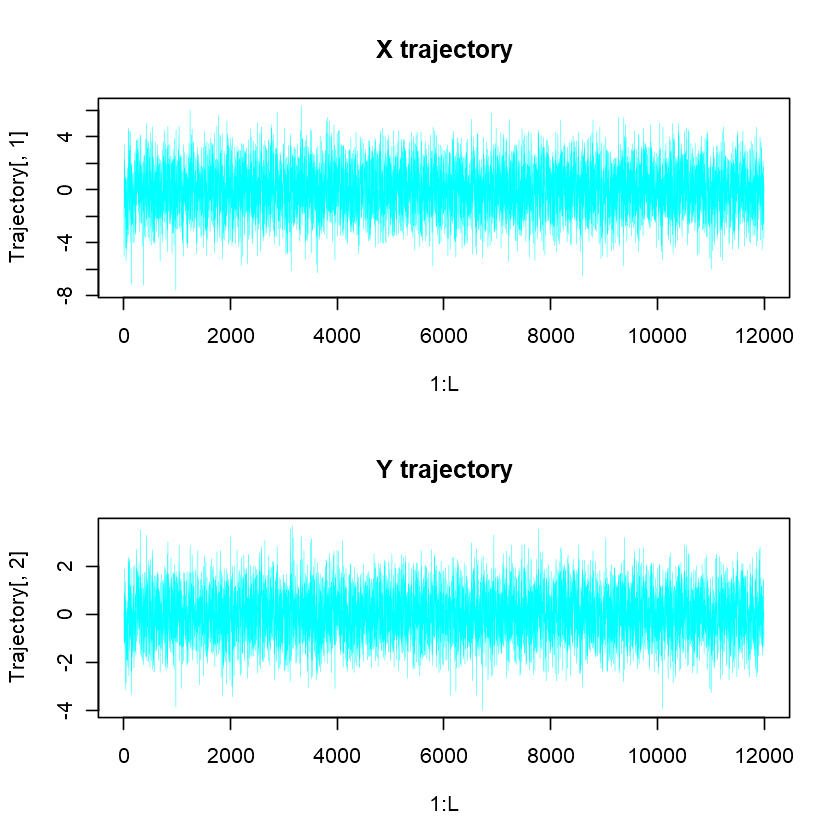

In [13]:
old.par<-par(mfrow=c(2,1))
plot(1:L,Trajectory[,1],"l",col="cyan",lwd=0.3,main="X trajectory")
plot(1:L,Trajectory[,2],"l",col="cyan",lwd=0.3,main="Y trajectory")
par(old.par)

#### Autocorrelation and thinning

Autocorrelation plot for each component of the original trajectory

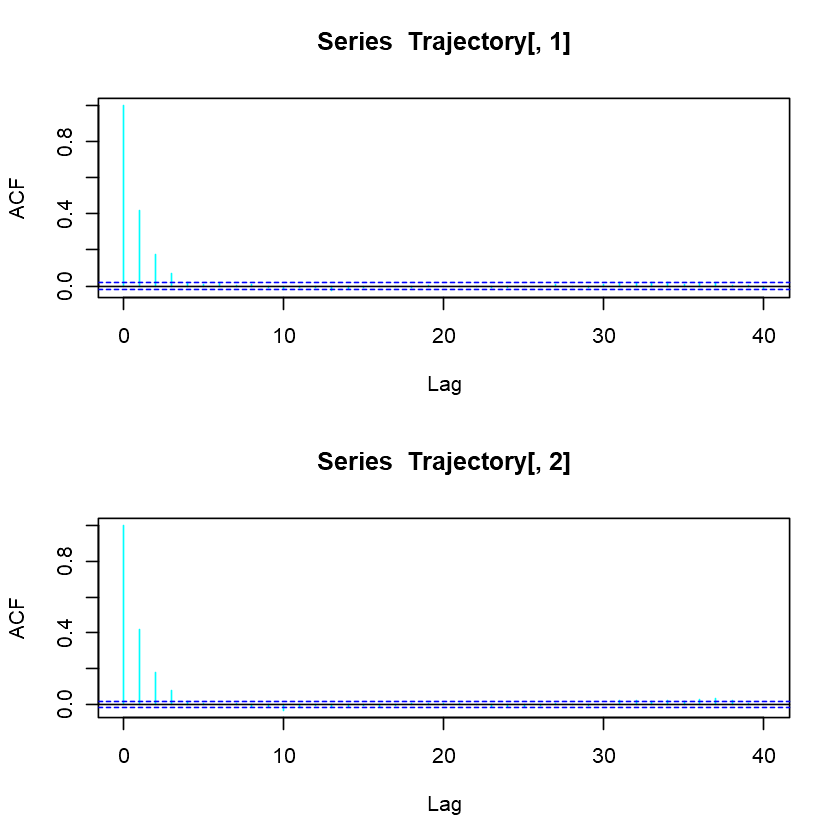

In [14]:
old.par<-par(mfrow=c(2,1))
acf(Trajectory[,1],col="cyan")
acf(Trajectory[,2],col="cyan")
par(old.par)

Thinning step

In [15]:
thinning.step<-3
L.thin<-floor(L/thinning.step)
I.thin<-thinning.step*(1:L.thin)
thinned.Trajectory<-Trajectory[I.thin,]

Autocorrelation plot for each component of the thinned trajectory

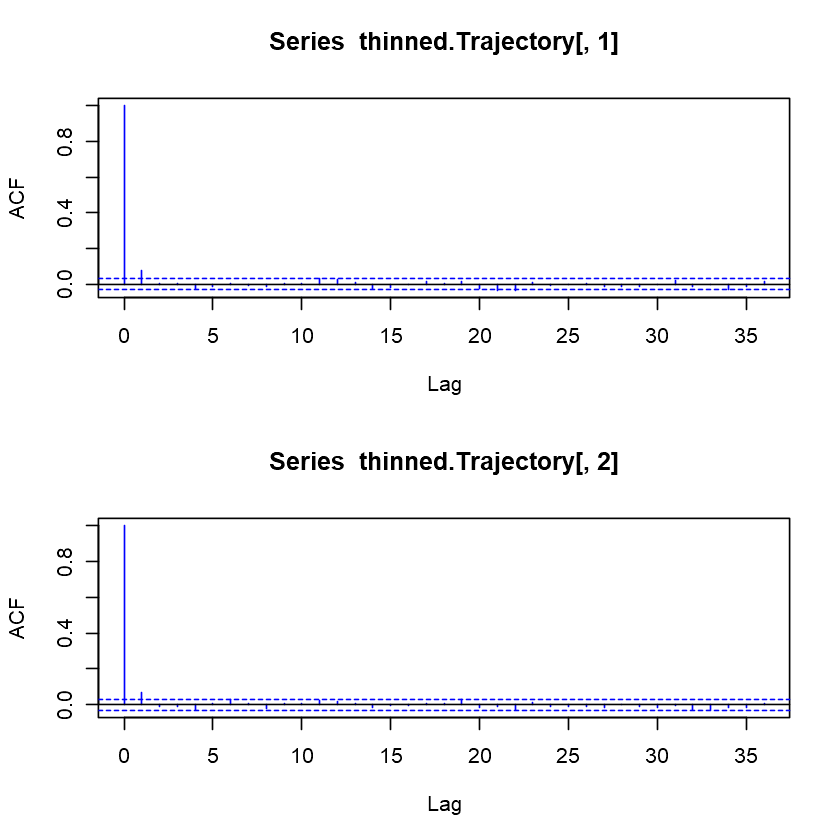

In [16]:
old.par<-par(mfrow=c(2,1))
acf(thinned.Trajectory[,1],col="blue")
acf(thinned.Trajectory[,2],col="blue")
par(old.par)

Bivariate autocorrelation plot

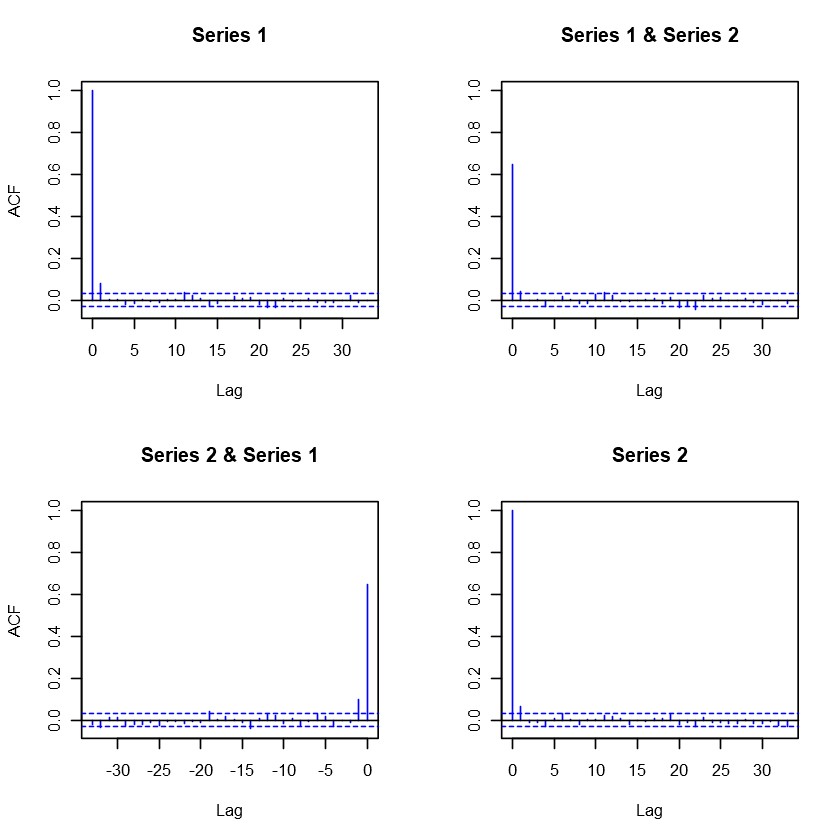

In [18]:
acf(thinned.Trajectory,col="blue")

#### Histograms

With the thinned trajectories

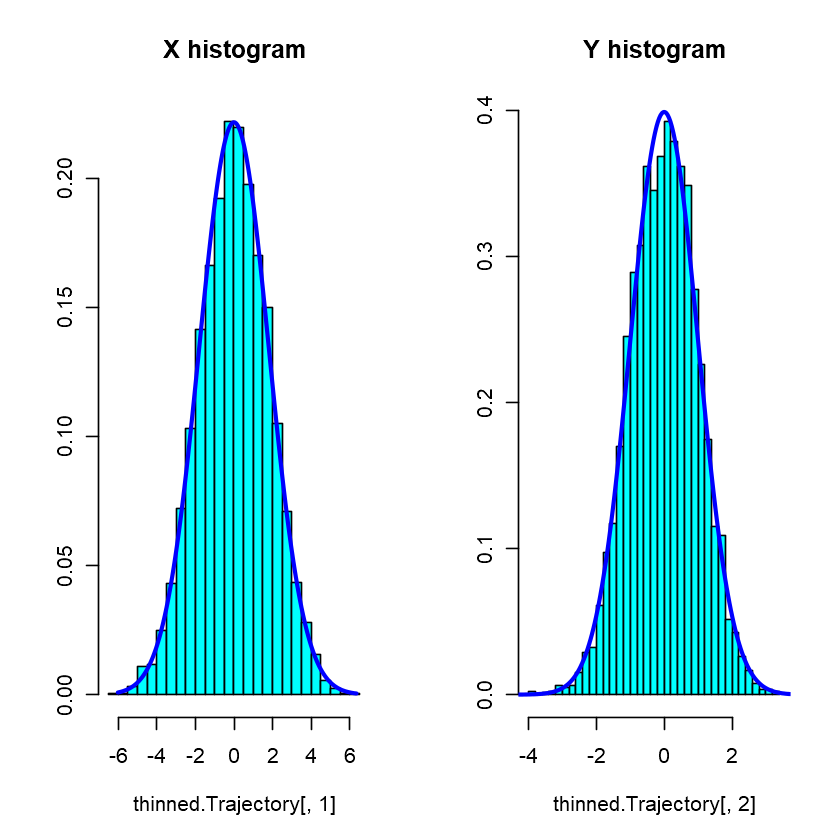

In [19]:
x.min<-min(thinned.Trajectory[,1],thinned.Trajectory[,2])
x.max<-max(thinned.Trajectory[,1],thinned.Trajectory[,2])
u<-seq(x.min,x.max,length=300)
old.par<-par(mfrow=c(1,2))
truehist(thinned.Trajectory[,1],main="X histogram")
lines(u,dnorm(u,mean=0,sd=sx),lwd=2.5,col="blue")
truehist(thinned.Trajectory[,2],main="Y histogram")
lines(u,dnorm(u,mean=0,sd=sy),lwd=2.5,col="blue")
par(old.par)

#### Hexbin plot 

(see [R-Bloggers entry on 2D histograms](https://www.r-bloggers.com/5-ways-to-do-2d-histograms-in-r/))

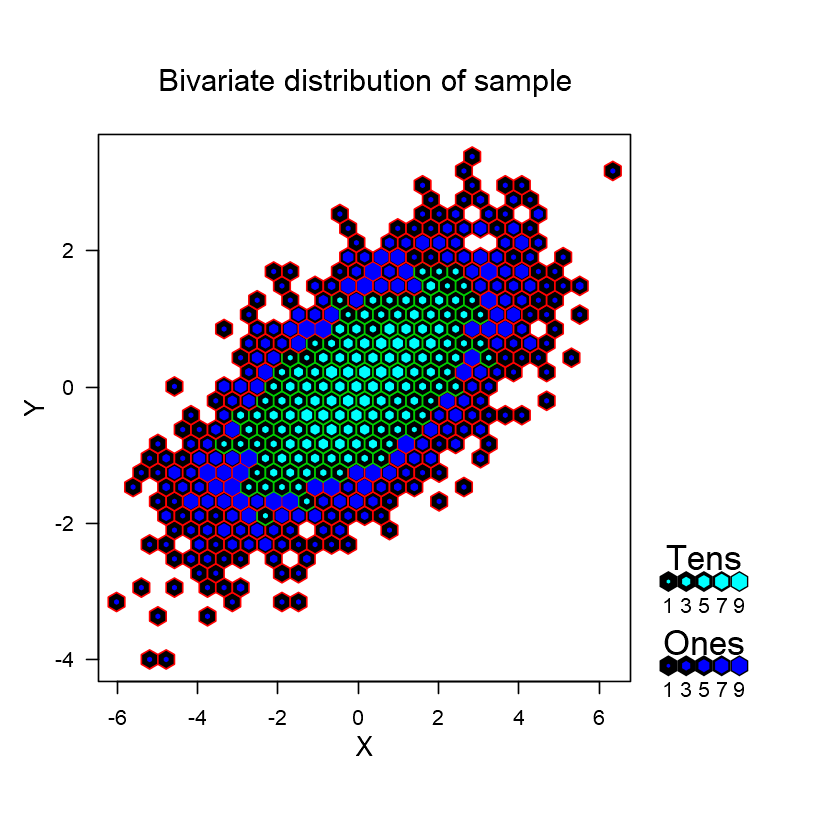

In [20]:
rf<-colorRampPalette(rev(brewer.pal(11,'Spectral')))
Trajectory.hexbin<-hexbin(thinned.Trajectory)
#plot(Trajectory.hexbin,style= "colorscale",colramp=rf,xlab="X",ylab="Y")
plot(Trajectory.hexbin,style= "nested.lattice",colramp=rf,xlab="X",ylab="Y"
        ,main="Bivariate distribution of sample")